In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, auc, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from data_repository import DataRepository

# Chuẩn bị dữ liệu

In [2]:
data_repo = DataRepository("../.env")
#Unclean data
X_Train, y_train, X_validation, y_validation, X_test, y_test = data_repo.load_current_data(clean_data=False)

In [3]:
print(f"Train dataset: X: {X_Train.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {X_validation.shape}, y: {y_validation.shape}")
print(f"Test dataset X: {X_test.shape}, y{y_test.shape}")

Train dataset: X: (8649, 9000), y: (8649,)
Validation dataset: X: (1191, 9000), y: (1191,)
Test dataset X: (2160, 9000), y(2160,)


__Label encoder__

In [4]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [5]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


In [6]:
def evaluate_and_print_results(y_pred, y_pred_proba, y_test, label_encoder: LabelEncoder):
    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    #conf_matrix to return
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Tính toán F1-Score
    f1_macro = f1_score(y_test, y_pred, average='macro')
    #Precision and recall
    precision = precision_score(y_test, y_pred, average='macro')  
    recall = recall_score(y_test, y_pred, average='macro')
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_pred_proba[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values)  # Avoid division by zero if auc_values is empty
    #Revert transform
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    # Print results
    print(classification_report(y_test, y_pred))
    print()
    print("Custom reports")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score (Macro): {f1_macro}")
    print(f"Macro-average AUC (SVM): {macro_avg_auc}")
    return conf_matrix

def plot_auc_curve(y_pred_proba, y_test, label_encoder: LabelEncoder):
    sns.set(font_scale=1.5)
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        class_name = label_encoder.inverse_transform([i])[0]
        y_test_class = np.where(y_test == i, 1, 0)
        fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_conf_matrix(conf_matrix):
    sns.set(font_scale=2)
    # Define the class labels
    class_labels = ['error', 'normal', 'overcurrent', 'overheating', 'zero']
    # Create a dataframe from the confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    # Set the plot size
    plt.figure(figsize=(10, 7))
    # Plot the heatmap
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 25})
    # Set plot title and labels
    plt.xlabel('Predicted label', labelpad=15)
    plt.ylabel('True label', labelpad=15)
    plt.show()

# SVM

## Xây dựng mô hình

In [7]:
from sklearn.svm import SVC
svm_model_current = SVC(kernel='rbf', random_state=42, probability=True)
svm_model_current.fit(X_Train, y_train)

SVC(probability=True, random_state=42)

In [35]:
from sklearn.model_selection import GridSearchCV
# Define the parameters to be tested
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# Create an SVM model
svc = SVC()
# Use GridSearchCV to find the optimal kernel
grid = GridSearchCV(svc, param_grid, cv=5, verbose=10)
X_all = 
# Fit the model to the data
grid.fit(X_Train, y_train)
# Print the best parameters and score
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START kernel=linear...............................................
[CV 1/5; 1/4] END ................kernel=linear;, score=0.978 total time= 1.1min
[CV 2/5; 1/4] START kernel=linear...............................................
[CV 2/5; 1/4] END ................kernel=linear;, score=0.881 total time=  54.7s
[CV 3/5; 1/4] START kernel=linear...............................................
[CV 3/5; 1/4] END ................kernel=linear;, score=0.842 total time=  52.7s
[CV 4/5; 1/4] START kernel=linear...............................................
[CV 4/5; 1/4] END ................kernel=linear;, score=0.839 total time=  53.2s
[CV 5/5; 1/4] START kernel=linear...............................................
[CV 5/5; 1/4] END ................kernel=linear;, score=0.914 total time=  58.5s
[CV 1/5; 2/4] START kernel=poly.................................................
[CV 1/5; 2/4] END ..................kernel=poly;,

In [37]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,38.436009,3.789333,18.789308,1.715363,linear,{'kernel': 'linear'},0.978035,0.880925,0.841618,0.838728,0.913823,0.890626,0.051706,2
1,28.456391,3.455018,12.041554,1.579261,poly,{'kernel': 'poly'},0.921965,0.910983,0.879769,0.838728,0.917872,0.893863,0.031298,1
2,29.299810,2.376473,26.438329,2.229610,rbf,{'kernel': 'rbf'},0.978613,0.870520,0.836994,0.838728,0.913245,0.887620,0.053258,3
3,365.175468,30.104675,57.406407,3.843926,sigmoid,{'kernel': 'sigmoid'},0.040462,0.088439,0.024855,0.050289,0.061307,0.053071,0.021362,4


## Đánh giá mô hình

#### Validation set

In [8]:
svm_y_pred_val = svm_model_current.predict(X_validation)
svm_y_pred_proba_val = svm_model_current.predict_proba(X_validation)

              precision    recall  f1-score   support

       error       0.83      0.83      0.83       237
      normal       0.93      0.90      0.92       247
 overcurrent       0.98      1.00      0.99       237
 overheating       0.78      0.89      0.83       223
        zero       0.98      0.86      0.92       247

    accuracy                           0.90      1191
   macro avg       0.90      0.90      0.90      1191
weighted avg       0.90      0.90      0.90      1191


Custom reports
Precision: 0.8996967891958005
Recall: 0.8969126174516902
Accuracy: 0.8967254408060453
F1-Score (Macro): 0.8966896517386147
Macro-average AUC (SVM): 0.9923400227426067


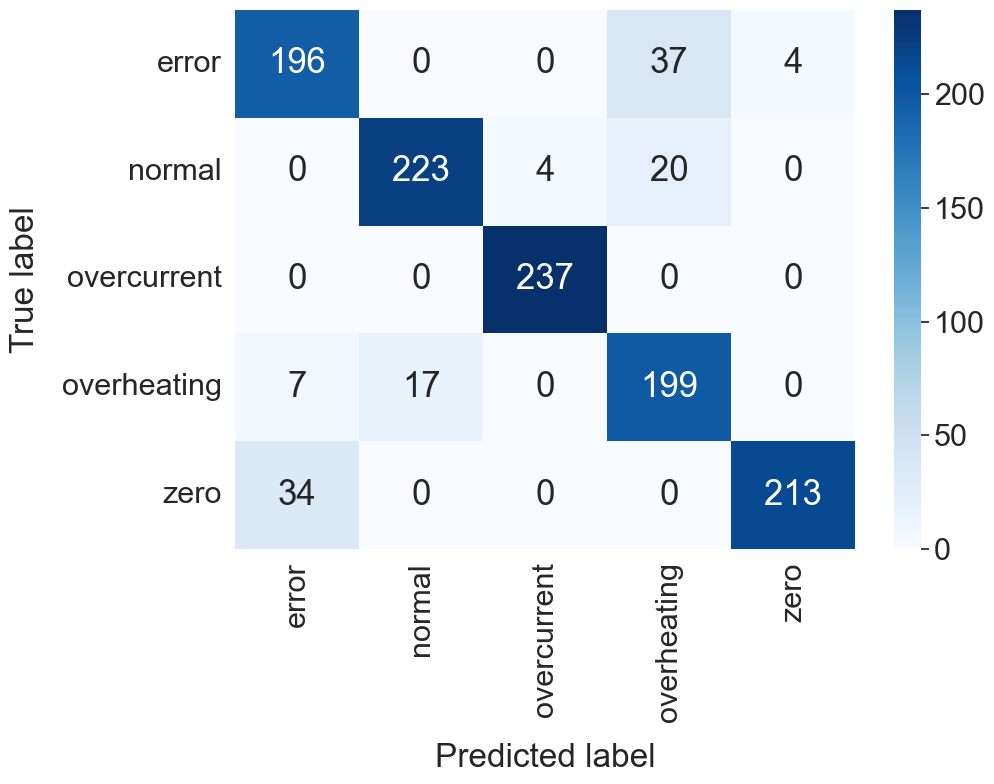

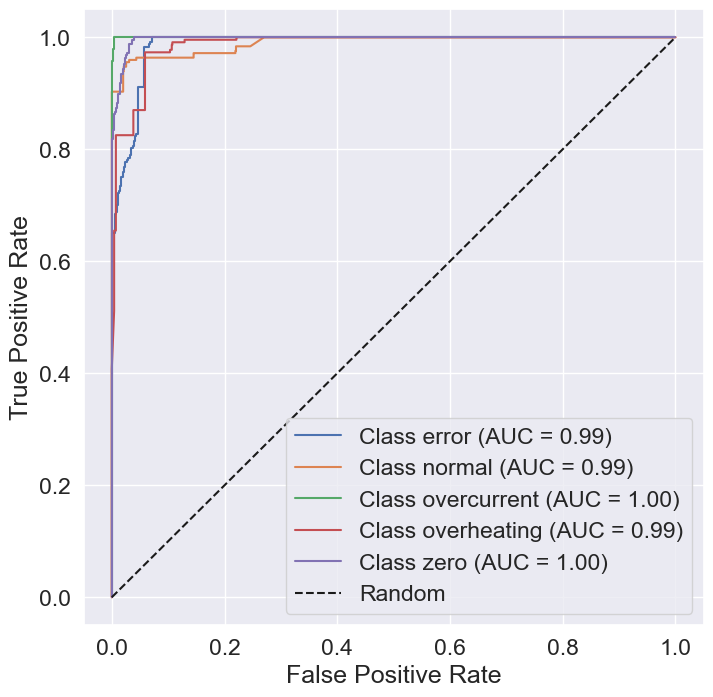

In [9]:
svm_val_conf_matrix = evaluate_and_print_results(y_pred=svm_y_pred_val, y_pred_proba=svm_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=svm_val_conf_matrix)
plot_auc_curve(y_pred_proba=svm_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

#### Test set

In [10]:
svm_y_pred = svm_model_current.predict(X_test)
svm_y_pred_proba = svm_model_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.85      0.85      0.85       445
      normal       0.92      0.93      0.93       419
 overcurrent       0.98      1.00      0.99       454
 overheating       0.81      0.89      0.85       411
        zero       0.99      0.87      0.93       431

    accuracy                           0.91      2160
   macro avg       0.91      0.91      0.91      2160
weighted avg       0.91      0.91      0.91      2160


Custom reports
Precision: 0.9123216830944187
Recall: 0.9095480727279899
Accuracy: 0.9101851851851852
F1-Score (Macro): 0.9098443588431671
Macro-average AUC (SVM): 0.9935049514639818


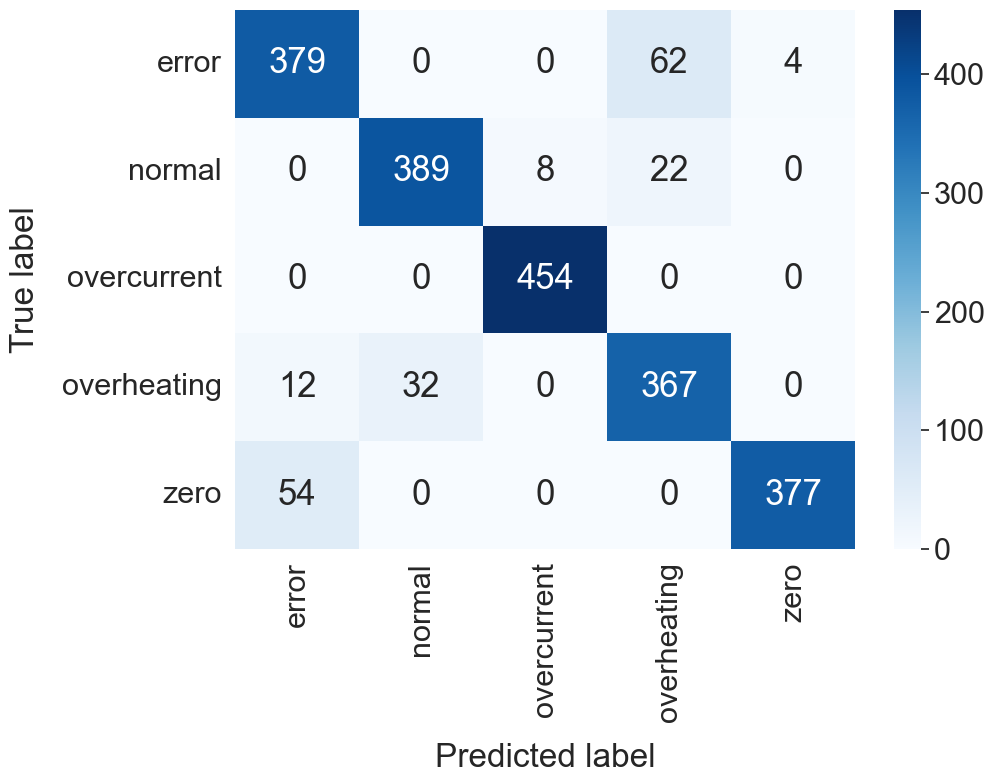

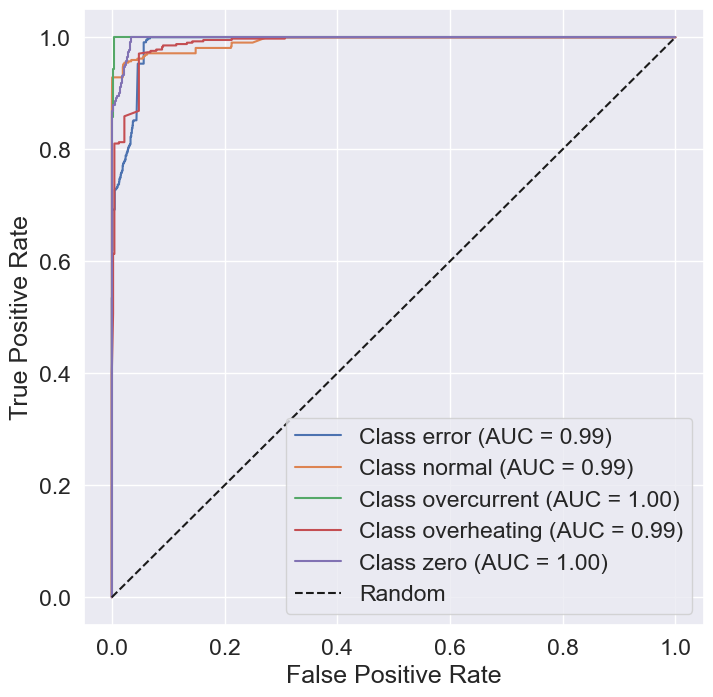

In [11]:
svm_conf_matrix = evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=svm_conf_matrix)
plot_auc_curve(y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

# Random Forest

## Xây dựng mô hình

In [28]:
# Tạo mô hình SVM
from sklearn.ensemble import RandomForestClassifier
rf_current = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_current.fit(X_Train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

## Đánh giá mô hình

#### Validation set

In [29]:
rf_y_pred_val = rf_current.predict(X_validation)
rf_y_pred_proba_val = rf_current.predict_proba(X_validation)

              precision    recall  f1-score   support

       error       0.90      0.95      0.92       237
      normal       1.00      0.91      0.95       247
 overcurrent       0.98      1.00      0.99       237
 overheating       0.93      0.99      0.96       223
        zero       0.95      0.91      0.93       247

    accuracy                           0.95      1191
   macro avg       0.95      0.95      0.95      1191
weighted avg       0.95      0.95      0.95      1191


Custom reports
Precision: 0.9515092719881277
Recall: 0.9516766140422119
Accuracy: 0.9504617968094039
F1-Score (Macro): 0.9506731100459467
Macro-average AUC (SVM): 0.9971114646156133


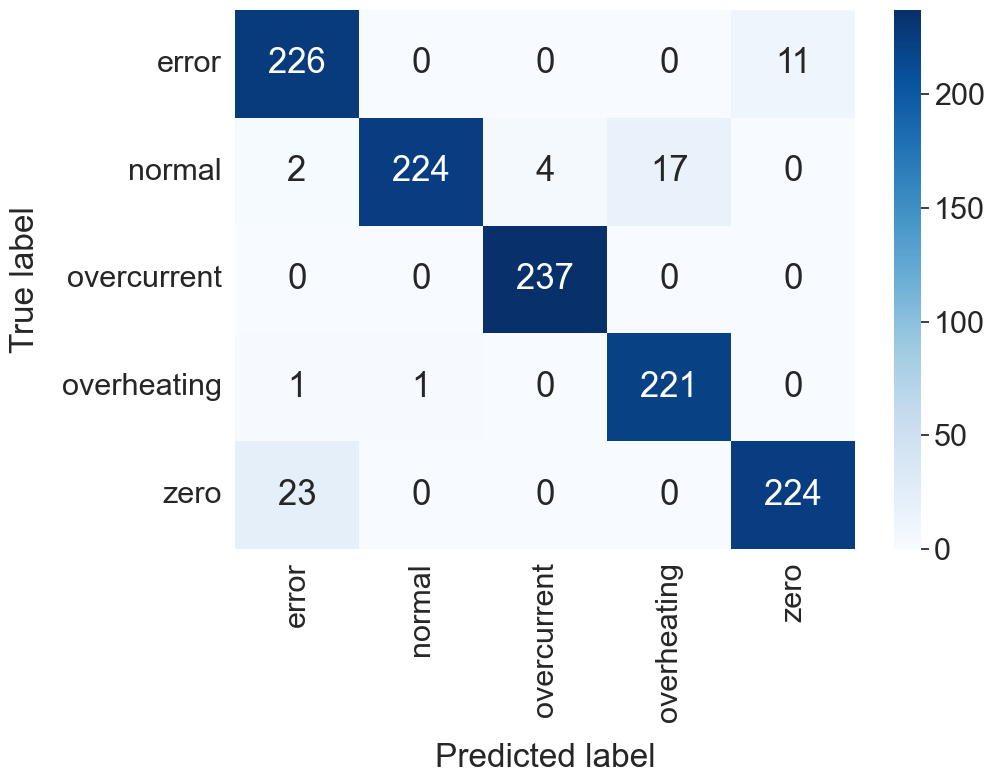

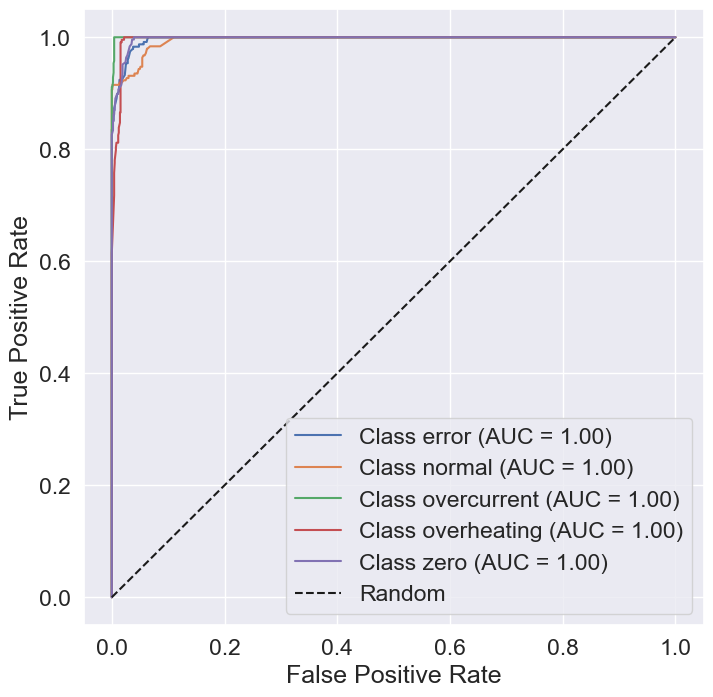

In [30]:
rf_val_cm = evaluate_and_print_results(y_pred=rf_y_pred_val, y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_val_cm)
plot_auc_curve(y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

#### Test set

In [31]:
rf_y_pred = rf_current.predict(X_test)
rf_y_pred_proba = rf_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.90      0.95      0.93       445
      normal       1.00      0.93      0.96       419
 overcurrent       0.98      1.00      0.99       454
 overheating       0.96      0.98      0.97       411
        zero       0.95      0.92      0.93       431

    accuracy                           0.96      2160
   macro avg       0.96      0.96      0.96      2160
weighted avg       0.96      0.96      0.96      2160


Custom reports
Precision: 0.9577635909160968
Recall: 0.9561489239534533
Accuracy: 0.9564814814814815
F1-Score (Macro): 0.956525868151888
Macro-average AUC (SVM): 0.9973591008672829


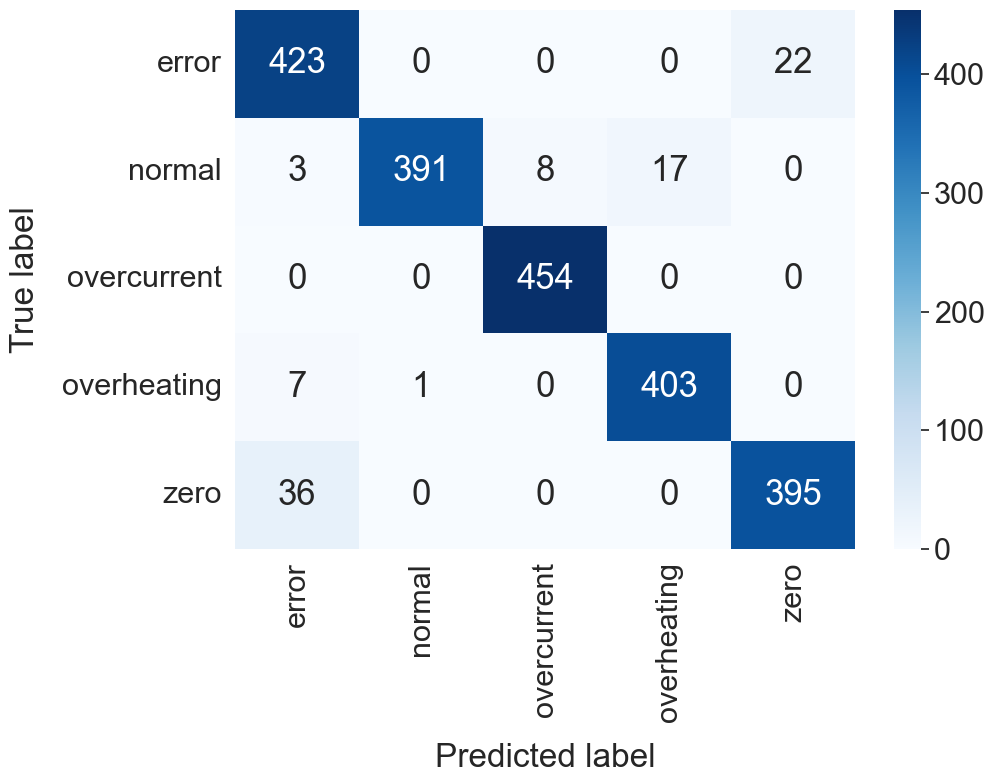

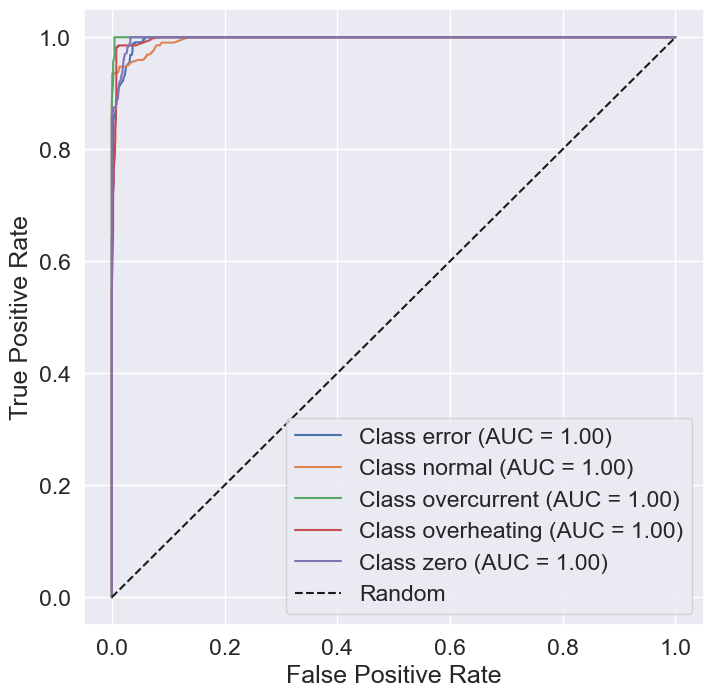

In [32]:
rf_cm = evaluate_and_print_results(y_pred=rf_y_pred, y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_cm)
plot_auc_curve(y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

# XgBoost

## Xây dựng mô hình

In [17]:
from xgboost import XGBClassifier
xgboost_current = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_current.fit(X_Train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Đánh giá mô hình

In [18]:
xgb_y_pred_val = xgboost_current.predict(X_validation)
xgb_y_pred_proba_val = xgboost_current.predict_proba(X_validation)

              precision    recall  f1-score   support

       error       0.89      0.93      0.91       237
      normal       0.95      0.91      0.93       247
 overcurrent       0.98      1.00      0.99       237
 overheating       0.92      0.95      0.93       223
        zero       0.94      0.91      0.92       247

    accuracy                           0.94      1191
   macro avg       0.94      0.94      0.94      1191
weighted avg       0.94      0.94      0.94      1191


Custom reports
Precision: 0.9380191759167168
Recall: 0.9384544296366908
Accuracy: 0.9378673383711167
F1-Score (Macro): 0.937971399401691
Macro-average AUC (SVM): 0.9953276239541152


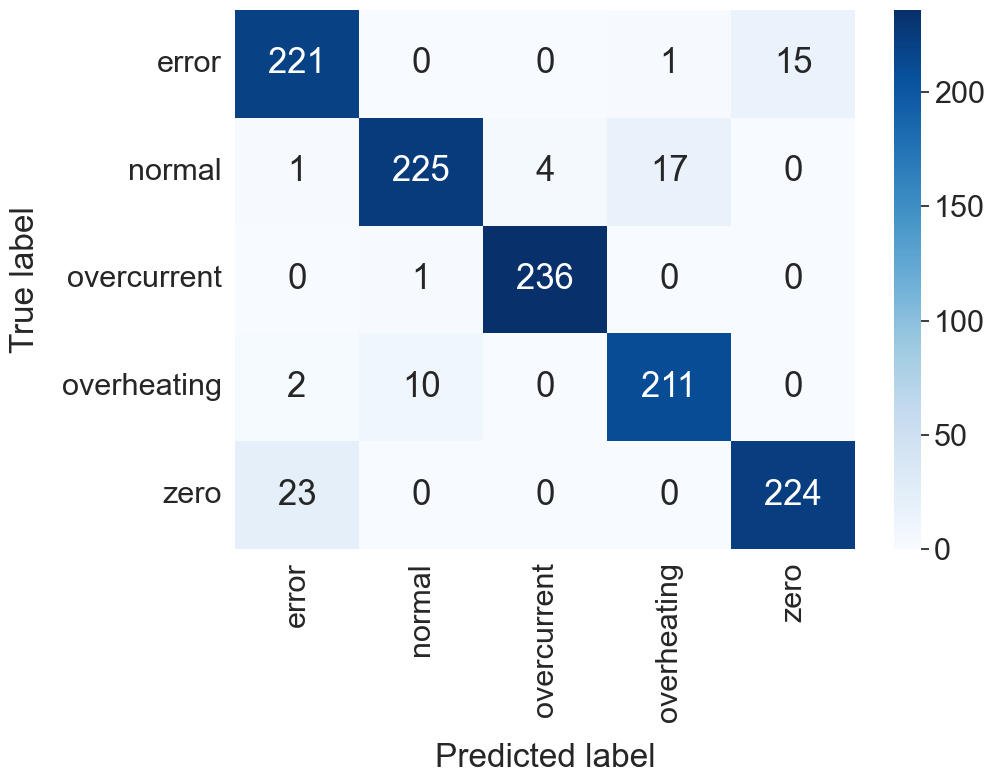

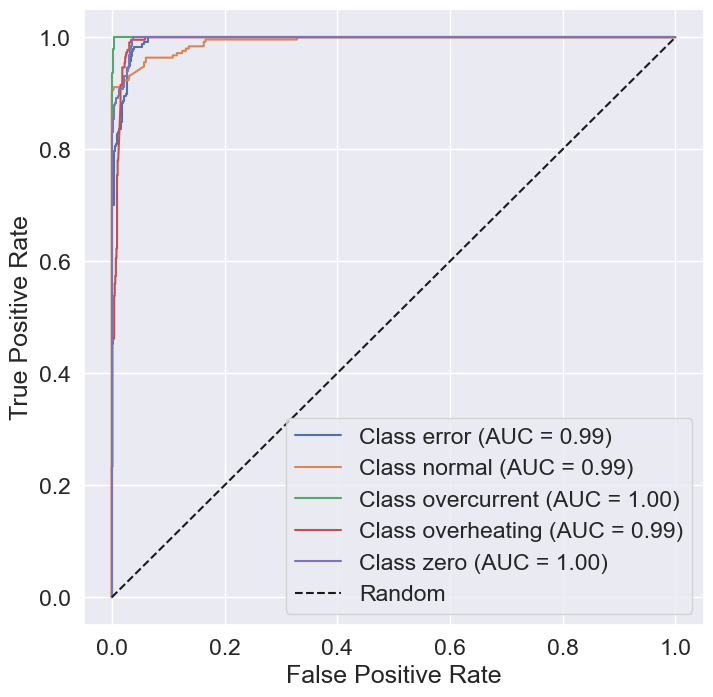

In [19]:
xgb_val_cm = evaluate_and_print_results(y_pred=xgb_y_pred_val, y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_val_cm)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

In [20]:
xgb_y_pred = xgboost_current.predict(X_test)
xgb_y_pred_proba = xgboost_current.predict_proba(X_test)

              precision    recall  f1-score   support

       error       0.90      0.94      0.92       445
      normal       0.92      0.94      0.93       419
 overcurrent       0.98      0.96      0.97       454
 overheating       0.95      0.93      0.94       411
        zero       0.94      0.92      0.93       431

    accuracy                           0.94      2160
   macro avg       0.94      0.94      0.94      2160
weighted avg       0.94      0.94      0.94      2160


Custom reports
Precision: 0.9378906925408803
Recall: 0.9371488034618405
Accuracy: 0.9375
F1-Score (Macro): 0.9373665315962239
Macro-average AUC (SVM): 0.9960531607190944


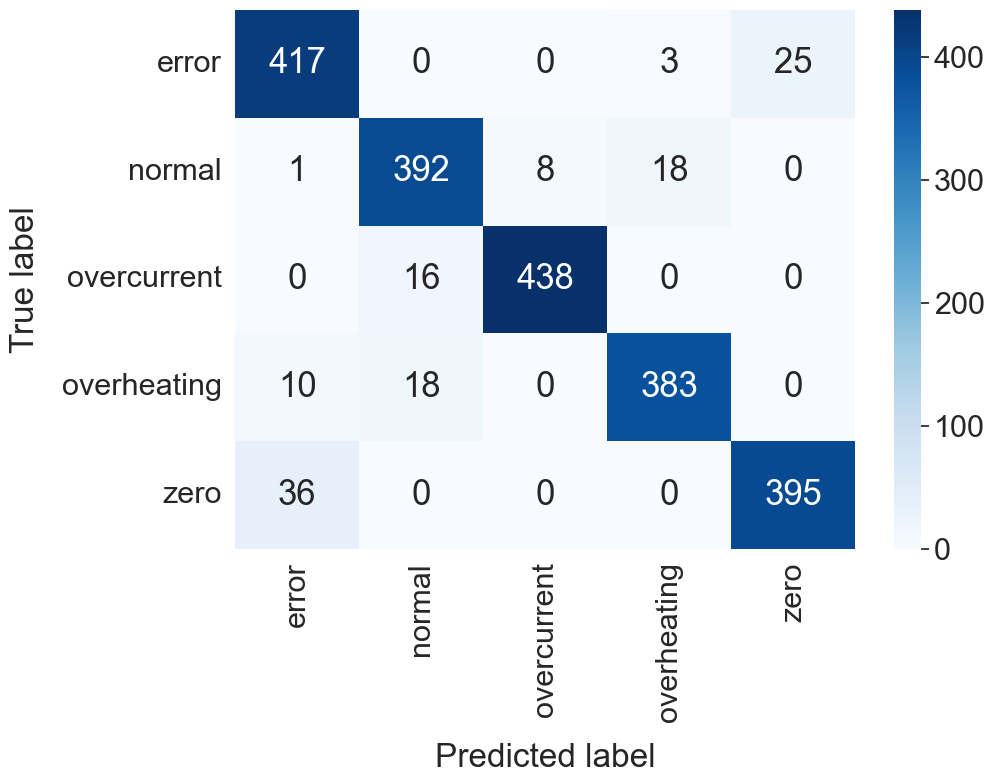

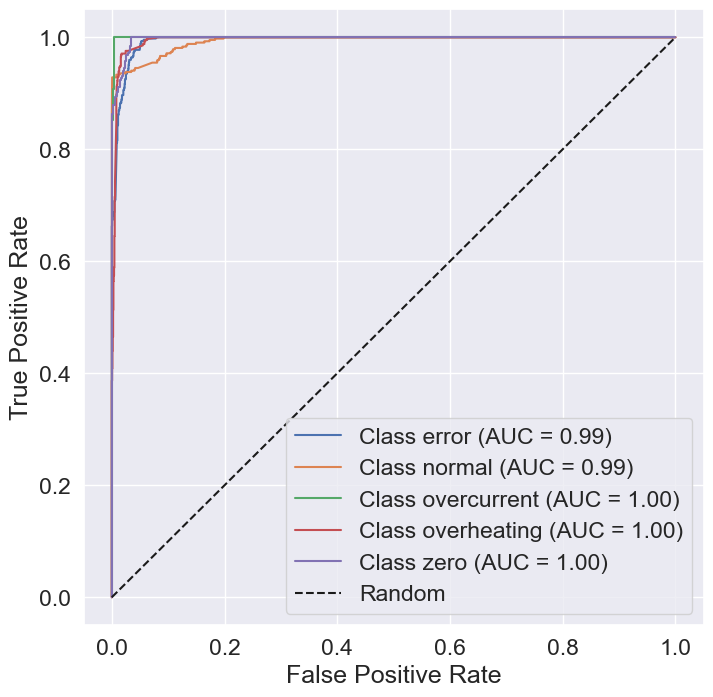

In [21]:
xgb_val_cm = evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_val_cm)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)